In [ ]:
!pip install torchdata -q

In [ ]:
import numpy as np
from functools import partial

from tqdm.notebook import tqdm, trange

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import torch
import torchtext
from torch import nn
from torch.utils.data import DataLoader
from torchtext.data import to_map_style_dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import WikiText2, WikiText103

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Word2vec CBOW
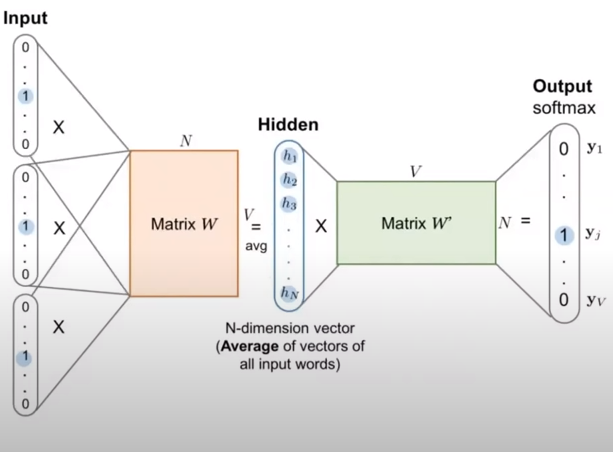

Мы научимся создавать векторы для слов по их контексту в текстовых корпусах. Такие модели называют word2vec. Существует 2 подхода: CBOW (continuous bag of words и skip-gram). Давайте разберём как устроен word2vec на примере CBOW.

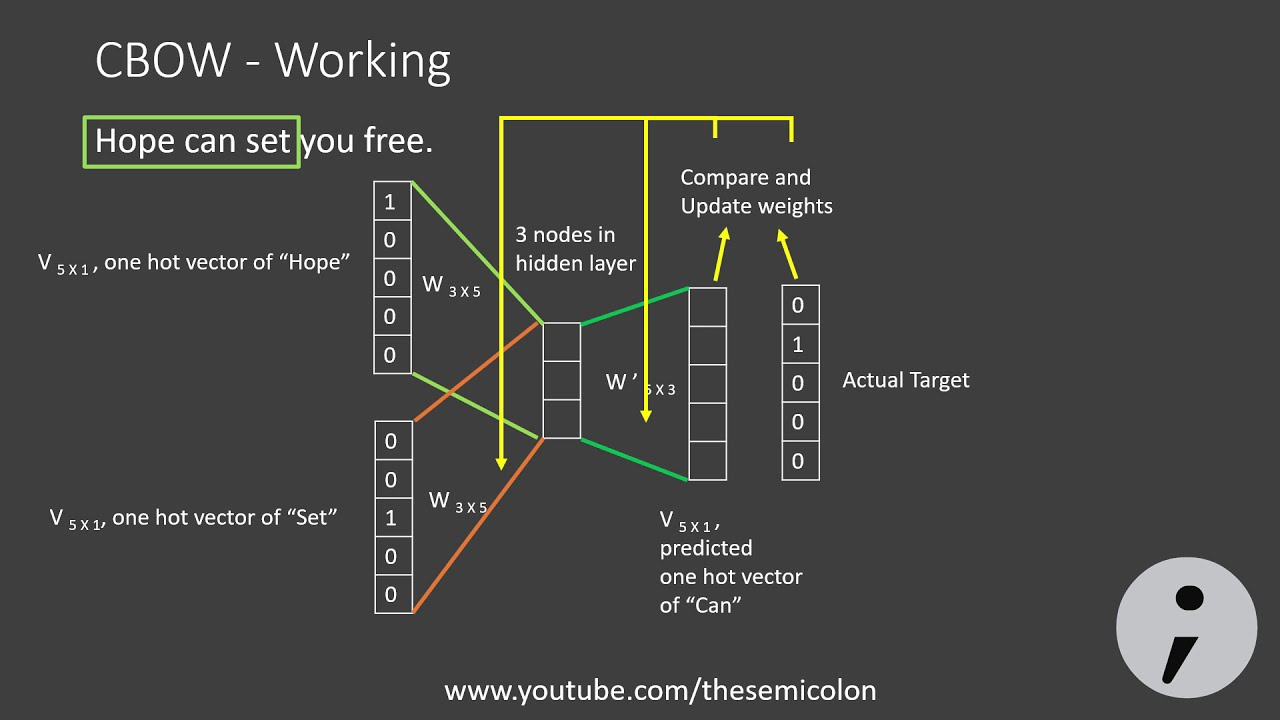

## Подготовим всё для обучения

In [ ]:
stopWords = set(stopwords.words('english'))

In [ ]:
tokenizer = get_tokenizer("basic_english", language="en")

data_iter = WikiText2(root='data', split=('train'))
data_iter = to_map_style_dataset(data_iter)

In [ ]:
vocab = build_vocab_from_iterator(
        map(lambda t: tokenizer(t[1]), data_iter),
        specials=["<unk>"],
        min_freq=18, #MIN_WORD_FREQUENCY
    )
vocab.set_default_index(vocab["<unk>"])
text_pipeline = lambda x: vocab(tokenizer(x))

In [ ]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, emb_dim=300):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.fc = nn.Linear(emb_dim, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        # mean
        x = x.mean(1)
        x = self.fc(x)
        return x

In [ ]:
CBOW_N_WORDS = 3
MIN_WORD_FREQ = 18
MAX_LEN = 60
EMB_DIM = 300
EMB_MAX_NORM = ...

In [ ]:
def collate_cbow(batch, text_pipeline=text_pipeline):
    ''' возвращает два списка.
    batch_input (X) - список списков с контекстом слов
    batch_output(Y) - список с целевым словом 
    '''
    batch_input, batch_output = [], []
    for text in batch:
        text_tokens_ids = text_pipeline(text)
        #print(text_tokens_ids)


        # игнорируйте короткие параграфы
        if len(text_tokens_ids) < 13:
            continue
        
        # обрезайте слишком длинные
        if len(text_tokens_ids) > MAX_LEN:
            text_tokens_ids = text_tokens_ids[:MAX_LEN]
        
        # обработка текста

        for idx in range(len(text_tokens_ids) - CBOW_N_WORDS * 2):
            # непрерывно проходим текст окном размера CBOW_N_WORDS * 2
            #window = text_tokens_ids[idx:idx+CBOW_N_WORDS]
            #context = window[text_tokens_ids[0], text_tokens_ids[2]]
            #print('idx', idx, 'idx+CBOW_N_WORDS', idx+CBOW_N_WORDS, 'text_tokens_ids', text_tokens_ids[idx:idx+CBOW_N_WORDS])
            window = text_tokens_ids[idx:idx+CBOW_N_WORDS]
            #print('context', window[0:CBOW_N_WORDS//2], window[CBOW_N_WORDS//2+1:])
            context = window[0:CBOW_N_WORDS//2] + window[CBOW_N_WORDS//2+1:]
            target = window[CBOW_N_WORDS // 2]
            #print('context', context)
            #print('target', target)
            target = window.pop(CBOW_N_WORDS // 2)
            batch_input.append(context)
            batch_output.append(target)

    batch_input = torch.tensor(batch_input, dtype=torch.long)
    batch_output = torch.tensor(batch_output, dtype=torch.long)
    return batch_input, batch_output

In [ ]:
batch_size=128
dataloader = DataLoader(
        data_iter,
        batch_size= batch_size,
        shuffle=True,
        collate_fn=collate_cbow,
)

In [ ]:
d = next(iter(dataloader))
d

(tensor([[0, 0],
         [0, 0],
         [0, 0],
         ...,
         [0, 0],
         [0, 0],
         [0, 0]]), tensor([0, 0, 0,  ..., 0, 0, 0]))

In [ ]:
model = CBOW(len(vocab))
optim = torch.optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss() 
# вспомните, crossentropyloss принимает `сырые` логиты и вектор с числами,
# по сути всё `горячее кодирование` осуществляется под капотом в pytorch

def train_cbow(model, optim, criterion):
    model.train()
    for e in trange(10):
        ep_loss = 0
        ep_acc = 0
        for x_b, y_b in tqdm(dataloader):
            optim.zero_grad()
            x_b.shape
            
            y_pred = model(x_b)

            loss = criterion(y_pred, y_b)
            #acc = binary_acc(y_pred, y_b.unsqueeze(1))

            loss.backward()
            optim.step()

            ep_loss += loss
            #ep_acc += acc

        print(f'Loss: {ep_loss/len(dataloader)}')

train_cbow(model, optim, criterion)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/287 [00:00<?, ?it/s]

Loss: 0.5968309044837952


  0%|          | 0/287 [00:00<?, ?it/s]

Loss: 0.2339719980955124


  0%|          | 0/287 [00:00<?, ?it/s]

Loss: 0.22401191294193268


  0%|          | 0/287 [00:00<?, ?it/s]

Loss: 0.21995864808559418


  0%|          | 0/287 [00:00<?, ?it/s]

Loss: 0.2174079567193985


  0%|          | 0/287 [00:00<?, ?it/s]

Loss: 0.2159574180841446


  0%|          | 0/287 [00:00<?, ?it/s]

Loss: 0.2149125635623932


  0%|          | 0/287 [00:00<?, ?it/s]

Loss: 0.21433256566524506


  0%|          | 0/287 [00:00<?, ?it/s]

Loss: 0.21393194794654846


  0%|          | 0/287 [00:00<?, ?it/s]

Loss: 0.21369841694831848


## Теперь напишем skip-gram аналогично

In [ ]:
# не успели :( 

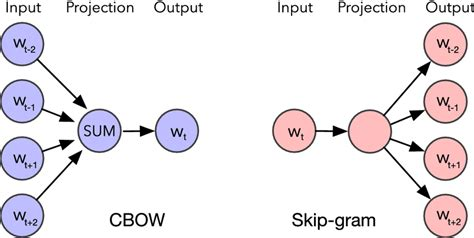

In [ ]:
def collate_skipgram(batch, text_pipeline=text_pipeline):
    pass

In [ ]:
class skipgram(nn.Module):
    pass

In [ ]:
from sklearn.decomposition import PCA